In [1]:
!pip install pafy youtube-dl moviepy
# helping to download youtube video

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 68.2 MB/s eta 0:00:00


In [2]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
import collections as deque
import matplotlib.pyplot as plt
from moviepy.editor import*
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import*
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [3]:
seed_constant=27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [4]:
%%capture
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
!unrar x UCF50.rar

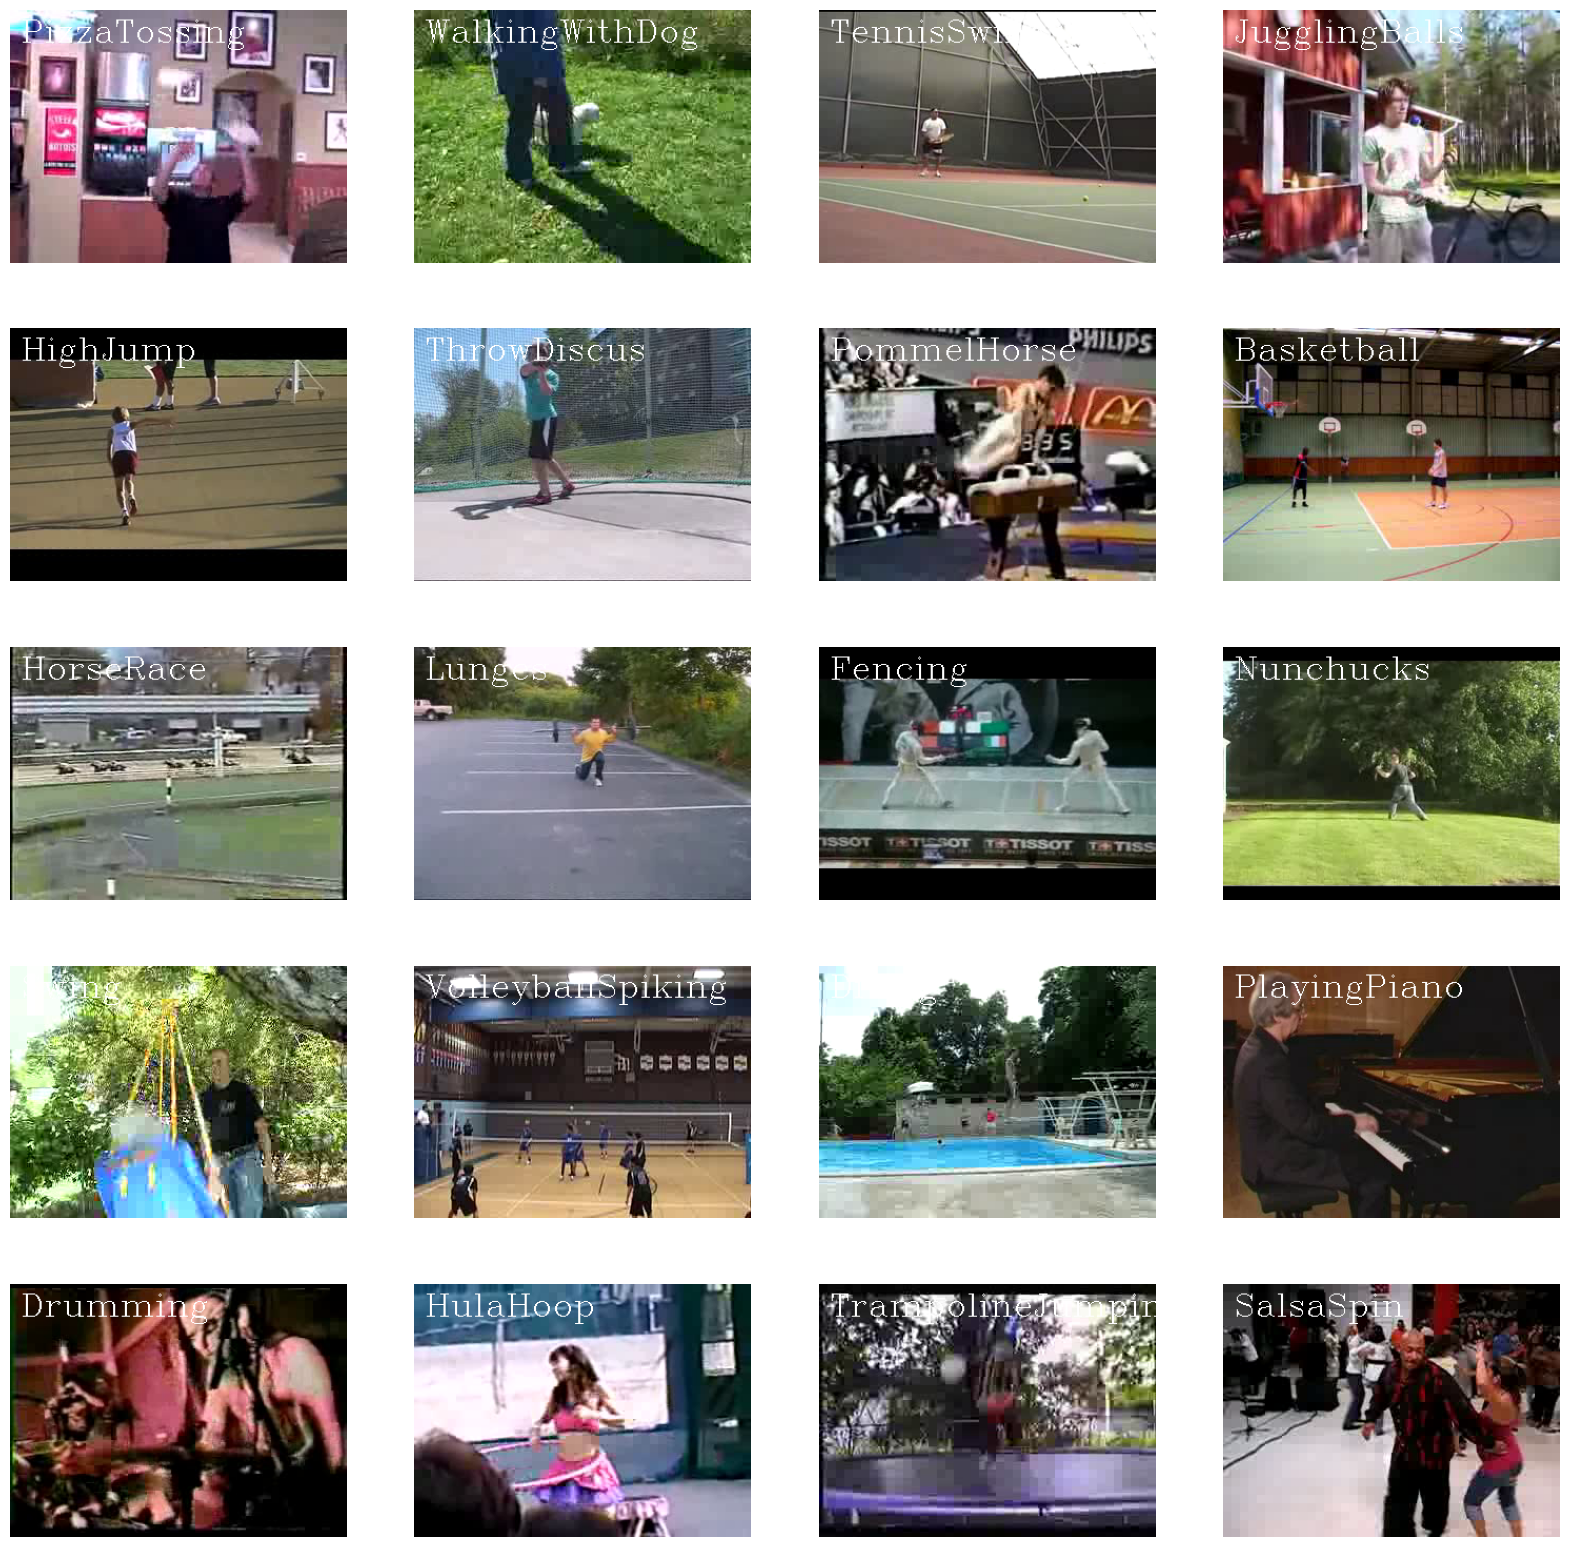

In [5]:
plt.figure(figsize=(20,20))
all_classes_names=os.listdir('UCF50')

random_range=random.sample(range(len(all_classes_names)),20)

for counter,random_index in enumerate(random_range,1):
  selected_class_name=all_classes_names[random_index]

  video_files_names_list=os.listdir(f'UCF50/{selected_class_name}')

  selcted_video_file_name=random.choice(video_files_names_list)

  video_reader=cv2.VideoCapture(f'UCF50/{selected_class_name}/{selcted_video_file_name}')
  _,bgr_frame=video_reader.read()
  video_reader.release()
  rgb_frame=cv2.cvtColor(bgr_frame,cv2.COLOR_BGR2RGB)
  cv2.putText(rgb_frame,selected_class_name,(10,30),cv2.FONT_HERSHEY_COMPLEX,1,(255,255,255),1)
  plt.subplot(5,4,counter)
  plt.imshow(rgb_frame)
  plt.axis('off')


In [6]:
Image_hight,Image_width=64,64
sequence_length=20
dataset_dir='UCF50'
classes_list=['BaseballPitch','Basketball','BenchPress','Biking','PlayingGuitar','WalkingWithDog','TaiChi','Swing','HorseRace','Punch']

In [7]:
def frames_extraction(video_path):
  frames_list=[]
  video_reader=cv2.VideoCapture(video_path)
  video_frames_count=int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frames_window=max(int(video_frames_count/sequence_length),1)
  for frame_counter in range(sequence_length):
    video_reader.set(cv2.CAP_PROP_POS_FRAMES,frame_counter*skip_frames_window)
    success,frame=video_reader.read()
    if not success:
      break
    resized_frame=cv2.resize(frame,(Image_hight,Image_width))
    normalized_frame=resized_frame/255
    frames_list.append(normalized_frame)

  video_reader.release()
  return frames_list

In [8]:
def create_dataset():
  features=[]
  labels=[]
  video_files_paths=[]
  for class_index,class_name in enumerate(classes_list):

    print(f'Extracting Data of class: {class_name}')
    files_list=os.listdir(os.path.join(dataset_dir,class_name))
    i=0;
    for file_name in files_list:
      video_file_path=os.path.join(dataset_dir,class_name,file_name)
      frames=frames_extraction(video_file_path)
      if len(frames)==sequence_length:
        features.append(frames)
        labels.append(class_index)
        video_files_paths.append(video_file_path)
  features=np.asarray(features)
  labels=np.array(labels)
  return features,labels,video_files_paths


In [9]:
features,labels,video_files_path=create_dataset()

Extracting Data of class: BaseballPitch
Extracting Data of class: Basketball
Extracting Data of class: BenchPress
Extracting Data of class: Biking
Extracting Data of class: PlayingGuitar
Extracting Data of class: WalkingWithDog
Extracting Data of class: TaiChi
Extracting Data of class: Swing
Extracting Data of class: HorseRace
Extracting Data of class: Punch


In [10]:
features.shape

(1399, 20, 64, 64, 3)

In [11]:
one_hot_encoded_labels=to_categorical(labels)

In [12]:
features_train,features_test,labels_train,labels_test=train_test_split(features,one_hot_encoded_labels,test_size=0.25,
                                                                       shuffle=True,random_state=seed_constant)

In [13]:
from warnings import filters
def create_complete_model():
  model=Sequential()
  model.add(ConvLSTM2D(filters=4,kernel_size=(3,3),activation='tanh',data_format='channels_last',
                       recurrent_dropout=0.2,return_sequences=True,input_shape=(sequence_length,Image_hight,Image_width,3)))
  model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters=8,kernel_size=(3,3),activation='tanh',data_format='channels_last',
                       recurrent_dropout=0.2,return_sequences=True,input_shape=(sequence_length,Image_hight,Image_width,3)))
  model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))


  model.add(ConvLSTM2D(filters=16,kernel_size=(3,3),activation='tanh',data_format='channels_last',
                       recurrent_dropout=0.2,return_sequences=True,input_shape=(sequence_length,Image_hight,Image_width,3)))
  model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(Flatten())

  model.add(Dense(len(classes_list),activation='softmax'))

  model.summary()
  return model

In [14]:
model=create_complete_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

In [15]:
early_stopping_callback=EarlyStopping(monitor='val_loss',patience=1,mode='min',restore_best_weights=True )
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics='accuracy')

In [16]:
model.fit(x=features_train,y=labels_train,epochs=50,batch_size=4,shuffle=True,validation_split=0.2,callbacks=[early_stopping_callback])

Epoch 1/50
210/210 [==============================] - 264s 1s/step - loss: 2.0625 - accuracy: 0.2515 - val_loss: 1.4973 - val_accuracy: 0.4667
Epoch 2/50
210/210 [==============================] - 248s 1s/step - loss: 1.2699 - accuracy: 0.5828 - val_loss: 1.1618 - val_accuracy: 0.6143
Epoch 3/50
210/210 [==============================] - 258s 1s/step - loss: 0.8295 - accuracy: 0.7318 - val_loss: 1.0167 - val_accuracy: 0.6619
Epoch 4/50
210/210 [==============================] - 249s 1s/step - loss: 0.5908 - accuracy: 0.7926 - val_loss: 1.1282 - val_accuracy: 0.6333


In [17]:
model_evaluation_history=model.evaluate(features_test,labels_test)

11/11 [==============================] - 28s 3s/step - loss: 0.9556 - accuracy: 0.6886


In [19]:
model_evaluation_loss,model_eva_accuray=model_evaluation_history


date_time_format='%Y_%m_%d_%H_%M_%S'
current_date_time_dt=dt.datetime.now()
current_date_time_string=dt.datetime.strftime(current_date_time_dt,date_time_format)

model_file_name=f'model_date_Time{current_date_time_string}__Loss_{model_evaluation_loss}_Accuracy_{model_eva_accuray}.h5'

model.save(model_file_name)

In [20]:
def plot_metric(model_training_history,metric_name_1,metric_name_2,plot_name):
  metric_value_1=model_training_history.history[metric_name_1]
  metric_value_2=model_training_history.history[metric_name_2]

  epochs=range(len(metric_value_1))

  plt.plot(epochs,metric_value_1,'blue',label=metric_name_1)
  plt.plot(epochs,metric_value_2,'red',label=metric_name_2)

  plt.title(str(plot_name))

  plt.legend()